## Demo for project 1

In [7]:
import torch
import torchvision

### Define dataset and dataloader

In [8]:
%load_ext autoreload
%autoreload 2

from dataset import load_dataset

trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=0)
testset = load_dataset(train=False)

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 100/100 [00:00<00:00, 49985.75it/s]


### Check dataset and dataloader

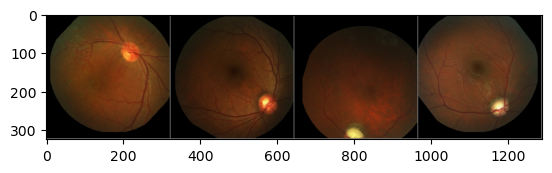

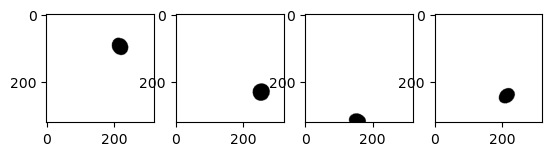

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # The data need to be normalized and unnormalized to keep the same
    # img = img / 255
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, targets = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print(names)
for i in range(batch_size):
    target_np = torch.argmax(targets[i], dim=0).cpu().numpy()
    plt.subplot(1,batch_size,i+1)
    
    plt.imshow(target_np,cmap='gray')


### Q1: Domain generalization example.

In [10]:
from dataset import domain_generization, load_dataset
# trainset_temp, _ = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=False)
trainset_temp, _ = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=0)

100%|██████████| 100/100 [00:00<00:00, 49991.70it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


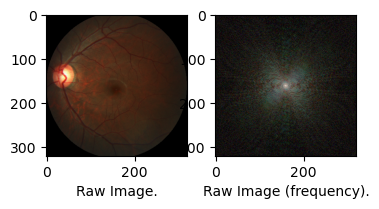

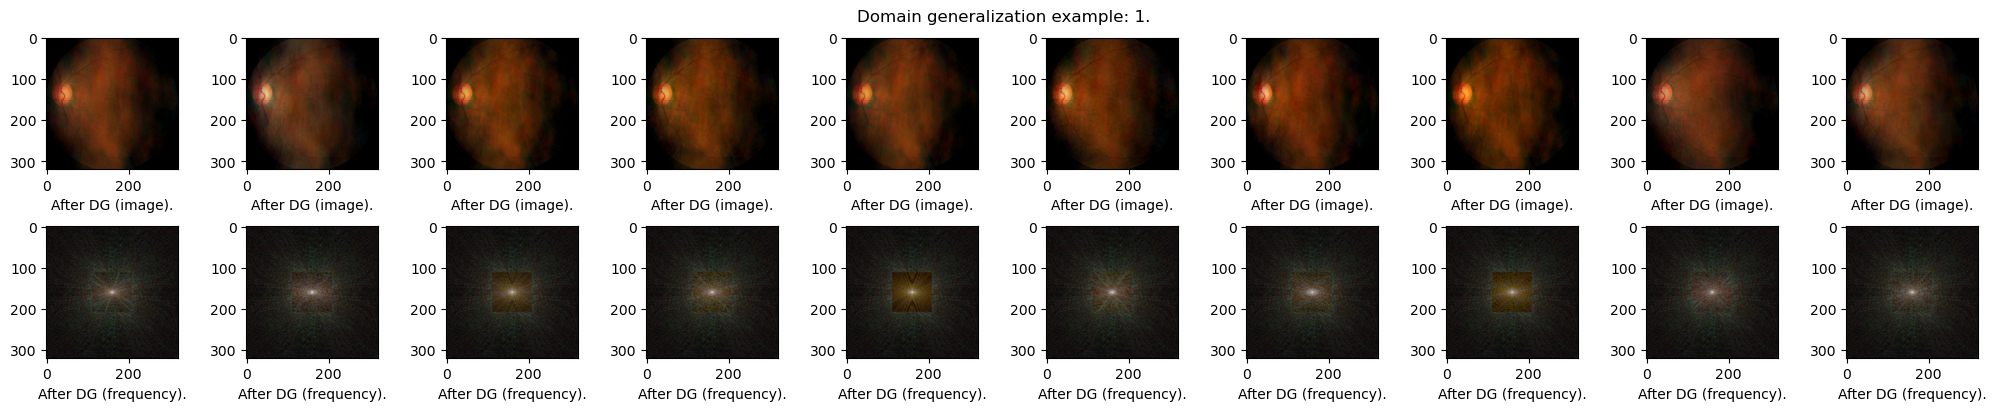

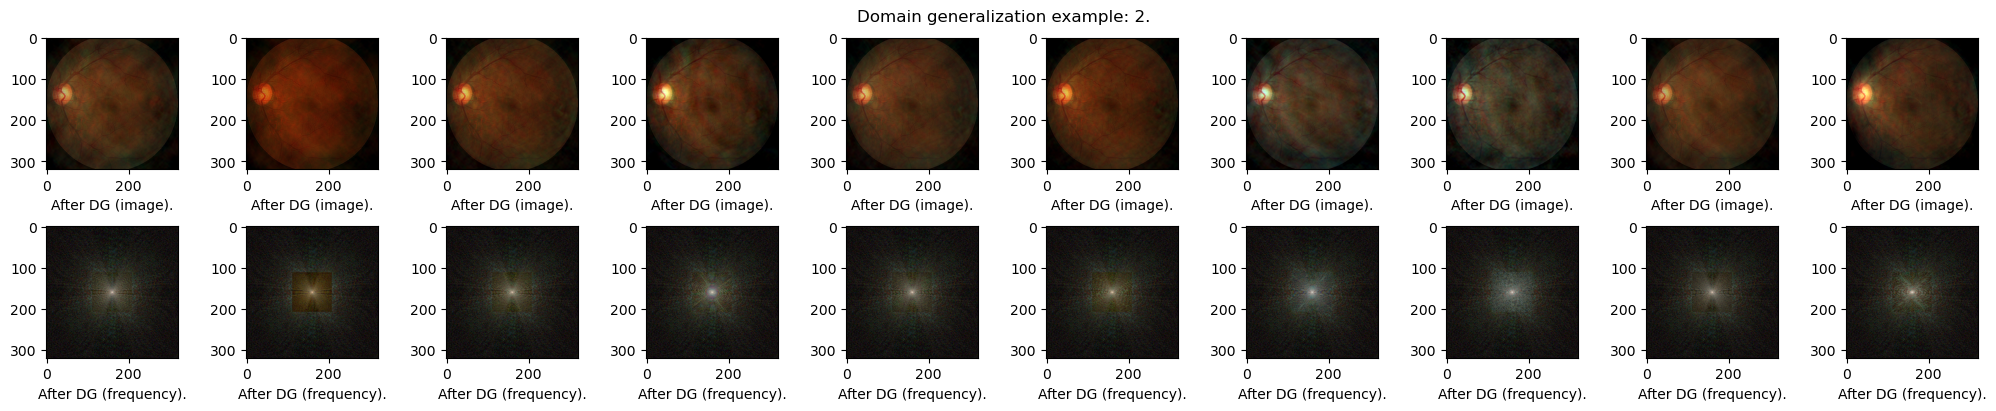

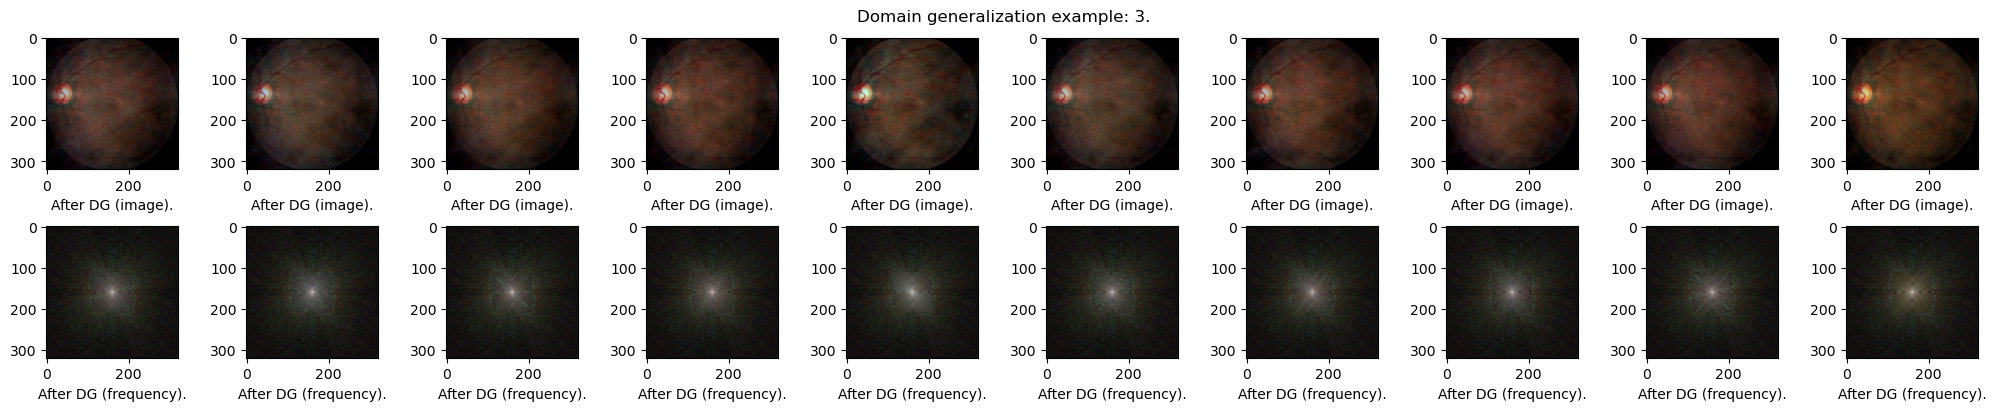

In [13]:
import matplotlib.pyplot as plt
import numpy as np
original_image, _ = trainset_temp.__getitem__(0) # Use the first image in training set.
original_image = original_image / 2 + 0.5
original_image = original_image.numpy()
scaling_factor = 0.3 # 替换低频区域所占大小
ratio = 1 #替换区域中目标域图片的幅度比重 
num_generalized=10
# domains = ['domain1','domain2','domain3'] # 可选：'random'（默认随机选择domain）, 'domain1', 'domain2', 'domain3'.
domains = [1,2,3] # 可选：'random'（默认随机选择domain）, 'domain1', 'domain2', 'domain3'.
original_image_freq = np.fft.fftshift(np.fft.fft2(original_image,axes=(-2,-1)),axes=(-2,-1))
original_image_freq = np.log(np.abs(original_image_freq))/np.max(np.log(np.abs(original_image_freq))) # log and normalize
plt.figure(figsize=[4,2])
plt.subplot(1,2,1), plt.imshow(np.transpose(original_image, (1, 2, 0))), plt.xlabel('Raw Image.')
plt.subplot(1,2,2), plt.imshow(np.transpose(original_image_freq, (1, 2, 0))), plt.xlabel('Raw Image (frequency).')
dg_outputs_domains = []
for domain in domains:
    dg_outputs, dg_fre_outputs= np.array(domain_generization(original_image,scaling_factor, ratio,num_generalized,domain)) # 输出是一个float, 因为计算傅里叶变换的时候应该用float提高精度
    dg_outputs = np.real(dg_outputs)
    fig, axs = plt.subplots(2, num_generalized, figsize=(2*num_generalized, 2*2), layout="constrained")
    for i in range(num_generalized):
        dg_output = dg_outputs[i]
        dg_fre_output = dg_fre_outputs[i]
        dg_fre_output = np.log(np.abs(dg_fre_output))/np.max(np.log(np.abs(dg_fre_output))) # log and normalize
        axs[0,i].imshow(np.clip(np.transpose(dg_output, (1, 2, 0)),0,1)) # 转回int才可以直接imshow
        axs[0,i].set_xlabel('After DG (image).')
        axs[1,i].imshow(np.clip(np.transpose(dg_fre_output,(1,2,0)),0,1),cmap='gray')
        axs[1,i].set_xlabel('After DG (frequency).')
    plt.suptitle('Domain generalization example: {}.'.format(domain))
    dg_outputs_domains.append(dg_outputs)

Distances between 3 domains:
[[15.58882897 39.61707433 42.72289764]
 [39.61707433 23.05242767 24.13302236]
 [42.72289764 24.13302236 12.04150766]]


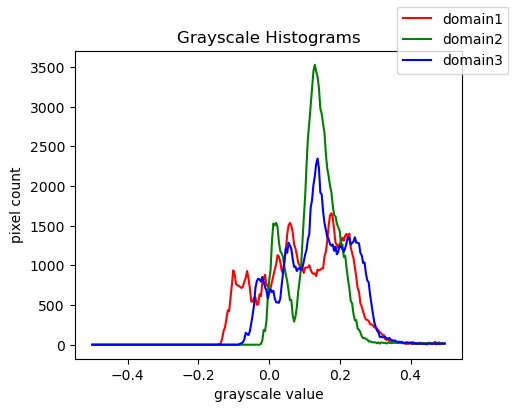

In [14]:
from dis_rep import norm_dist,CS_dist,intra_cluster_distance,inter_cluster_diatance
D = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        if i == j:
            D[i,j] = intra_cluster_distance(dg_outputs_domains[i],distance_metric=norm_dist,ord=None)
        else:
            D[i,j] = inter_cluster_diatance(dg_outputs_domains[i],dg_outputs_domains[j],distance_type=2,distance_metric=norm_dist,ord=None)[0]
print('Distances between 3 domains:')
print(D)
def rgb2gray(rgb):
    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:] # PIL读到图片是RGB顺序
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
domain1_gray_average = np.mean(rgb2gray(dg_outputs_domains[0]),axis=0)
domain2_gray_average = np.mean(rgb2gray(dg_outputs_domains[1]),axis=0)
domain3_gray_average = np.mean(rgb2gray(dg_outputs_domains[2]),axis=0)
histogram1, bin_edges1 = np.histogram(domain1_gray_average, bins=256, range=(-0.5, 0.5))
histogram2, bin_edges2 = np.histogram(domain2_gray_average, bins=256, range=(-0.5, 0.5))
histogram3, bin_edges3 = np.histogram(domain3_gray_average, bins=256, range=(-0.5, 0.5))
plt.figure(figsize=(5,4))
plt.title("Grayscale Histograms")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.plot(bin_edges1[0:-1], histogram1,'r', bin_edges2[0:-1], histogram2, 'g', bin_edges3[0:-1], histogram3, 'b')
plt.figlegend(["domain1","domain2","domain3"],loc='upper right')

### Define loss function and optimizer

In [15]:
import torch
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self,weight=None,size_average = True):
        super(DiceBCELoss, self).__init__()
    def forward(self,inputs,targets,smooth=1):
        inputs = F.sigmoid(inputs)
        batch_number = targets.size(0)
        # inputs = inputs[:,0,:,:]
        Dice_BCE = 0
        for i in range(2):
            a = inputs[:,i].view(batch_number,-1)
            b = targets[:,i].view(batch_number,-1)
            intersection = (a*b).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
            Dice_BCE += dice_loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = Dice_BCE + BCE
        return Dice_BCE

### Define a model

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import torch

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
# print(net)

In [17]:

import torch.optim as optim
import torch.nn as nn


criterion = DiceBCELoss()
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = net.to(device)
criterion = criterion.to(device)

cuda


### Train network

In [19]:
import torch
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self,weight=None,size_average = True):
        super(DiceBCELoss, self).__init__()
    def forward(self,inputs,targets,smooth=1):
        inputs = F.sigmoid(inputs)
        batch_number = targets.size(0)
        # inputs = inputs[:,0,:,:]
        Dice_BCE = 0
        for i in range(2):
            a = inputs[:,i].view(batch_number,-1)
            b = targets[:,i].view(batch_number,-1)
            intersection = (a*b).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
            Dice_BCE += dice_loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = Dice_BCE + BCE
        return Dice_BCE


%load_ext autoreload
%autoreload 2

from dataset import load_dataset
import time

epoch_number = 20

for train_idx in range(7):
    """
    Train idx = 4: training for domain 1
    Train idx = 5: training for domain 2
    Train idx = 6: training for domain 3
    Train idx = 7: training for dynamic domain
    """
    

    #################### Model Define ######################
    import torch.nn as nn
    import torch.nn.functional as F
    import segmentation_models_pytorch as smp
    import torch

    net = smp.Unet(
        encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset)
    )

    import torch.optim as optim
    import torch.nn as nn


    criterion = DiceBCELoss()
    # criterion = nn.CrossEntropyLoss()
    # criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    net = net.to(device)
    criterion = criterion.to(device)

    #################### Model Define ######################

    if train_idx == 0:
        ############# No DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=0)
        PATH = ('./net_no_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./no_DG_epoch_%d.txt')%(epoch_number)
        ############# No DG #################
    elif train_idx == 1:
        # ############## DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=4)
        PATH = ('./net_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./DG_epoch_%d.txt')%(epoch_number)
        # ############## DG #################
    elif train_idx == 2:
        ############## Data argument + No DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=0)
        PATH = ('./net_Data_arg_no_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./Data_arg_no_DG_epoch_%d.txt')%(epoch_number)
        ############## Data argument + No DG #################
    elif train_idx == 3:
        # ############ Data argument +  DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=4)
        PATH = ('./net_Data_arg_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./Data_arg_DG_epoch_%d.txt')%(epoch_number)
        # ############## Data argument +  DG #################
    elif train_idx == 4:
        # ############ Data argument +  DG + Domain 1 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=1)
        PATH = ('./net_Data_arg_DG_D1_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./Data_arg_DG_D1_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 1 #################
    elif train_idx == 5:
        # ############ Data argument +  DG + Domain 2 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=2)
        PATH = ('./net_Data_arg_DG_D2_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./Data_arg_DG_D2_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 2 #################
    elif train_idx == 6:
        # ############ Data argument +  DG + Domain 3 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=3)
        PATH = ('./net_Data_arg_DG_D3_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./Data_arg_DG_D3_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 3 #################
    elif train_idx == 7:
        # ############ Data argument +  DG + Domain 1 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=1)
        PATH = ('./net_DG_D1_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./Data_DG_D1_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 1 #################
    else:
        print("outof model bound")
        break
    
    # trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=False)
    # trainset, valset = load_dataset(train=True,is_DG=False)

    log_file = open(log_file_name,'w')

    ########### Delete file content
    log_file.seek(0)
    log_file.truncate()
    ########### Delete file content



    batch_size = 4

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)


    for epoch in range(epoch_number):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (inputs, target) in enumerate(trainloader):
            

            inputs = inputs.to(device)
            target = target.to(device)
            # forward + backward + optimizeo 
            # change the data to float type
            outputs = net(inputs)
            # print(outputs.size())
            # outputs = torch.argmax(outputs, dim=1)
            # print((outputs.shape))
            # print(target.to(torch.float32).dtype)

            ############## Cross entropy Loss ##########
            # loss = criterion(outputs,target)
            #################### End ###################
            
            ############## Use dice loss ###############
            # outputs = torch.argmax(outputs, dim=1)
            # target = torch.argmax(target, dim=1)
            loss = criterion(outputs,target)
            # loss.requires_grad_(True)
            #################### End ###################

            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            log_file.write(("%f\n") % loss.item())
            # print(("%f\n") % loss.item())
            if i % 20 == 19:    # print every 20 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0
    log_file.close()
    ################## Temp Model Save ##############
    torch.save(net.state_dict(), PATH)
    print('Finished Training')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


100%|██████████| 100/100 [00:00<00:00, 50003.62it/s]
c:\Users\RZY\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,    20] loss: 1.679
[2,    20] loss: 1.380
[3,    20] loss: 1.206
[4,    20] loss: 1.083
[5,    20] loss: 0.955
[6,    20] loss: 0.797
[7,    20] loss: 0.598
[8,    20] loss: 0.396
[9,    20] loss: 0.253
[10,    20] loss: 0.182
[11,    20] loss: 0.142
[12,    20] loss: 0.121
[13,    20] loss: 0.106
[14,    20] loss: 0.095
[15,    20] loss: 0.086
[16,    20] loss: 0.079
[17,    20] loss: 0.075
[18,    20] loss: 0.072
[19,    20] loss: 0.067
[20,    20] loss: 0.064
Finished Training
cuda


100%|██████████| 100/100 [00:00<00:00, 99556.23it/s]


[1,    20] loss: 2.025
[2,    20] loss: 1.474
[3,    20] loss: 1.236
[4,    20] loss: 1.114
[5,    20] loss: 0.985
[6,    20] loss: 0.840
[7,    20] loss: 0.657
[8,    20] loss: 0.470
[9,    20] loss: 0.329
[10,    20] loss: 0.249
[11,    20] loss: 0.208
[12,    20] loss: 0.179
[13,    20] loss: 0.155
[14,    20] loss: 0.144
[15,    20] loss: 0.131
[16,    20] loss: 0.116
[17,    20] loss: 0.114
[18,    20] loss: 0.105
[19,    20] loss: 0.098
[20,    20] loss: 0.094
Finished Training
cuda


100%|██████████| 100/100 [00:00<00:00, 49944.08it/s]


[1,    20] loss: 2.033
[2,    20] loss: 1.472
[3,    20] loss: 1.244
[4,    20] loss: 1.126
[5,    20] loss: 1.024
[6,    20] loss: 0.914
[7,    20] loss: 0.784
[8,    20] loss: 0.614
[9,    20] loss: 0.447
[10,    20] loss: 0.330
[11,    20] loss: 0.246
[12,    20] loss: 0.206
[13,    20] loss: 0.174
[14,    20] loss: 0.159
[15,    20] loss: 0.143
[16,    20] loss: 0.129
[17,    20] loss: 0.123
[18,    20] loss: 0.116
[19,    20] loss: 0.105
[20,    20] loss: 0.105
Finished Training
cuda


100%|██████████| 100/100 [00:00<00:00, 51312.75it/s]


[1,    20] loss: 2.064
[2,    20] loss: 1.446
[3,    20] loss: 1.222
[4,    20] loss: 1.103
[5,    20] loss: 0.992
[6,    20] loss: 0.858
[7,    20] loss: 0.710
[8,    20] loss: 0.523
[9,    20] loss: 0.374
[10,    20] loss: 0.278
[11,    20] loss: 0.232
[12,    20] loss: 0.205
[13,    20] loss: 0.188
[14,    20] loss: 0.165
[15,    20] loss: 0.172
[16,    20] loss: 0.149
[17,    20] loss: 0.143
[18,    20] loss: 0.138
[19,    20] loss: 0.131
[20,    20] loss: 0.130
Finished Training
cuda


100%|██████████| 100/100 [00:00<00:00, 99532.61it/s]


[1,    20] loss: 1.738
[2,    20] loss: 1.411
[3,    20] loss: 1.246
[4,    20] loss: 1.149
[5,    20] loss: 1.060
[6,    20] loss: 0.948
[7,    20] loss: 0.812
[8,    20] loss: 0.644
[9,    20] loss: 0.471
[10,    20] loss: 0.338
[11,    20] loss: 0.270
[12,    20] loss: 0.227
[13,    20] loss: 0.198
[14,    20] loss: 0.180
[15,    20] loss: 0.166
[16,    20] loss: 0.156
[17,    20] loss: 0.140
[18,    20] loss: 0.146
[19,    20] loss: 0.130
[20,    20] loss: 0.123
Finished Training
cuda


100%|██████████| 100/100 [00:00<00:00, 24998.83it/s]


[1,    20] loss: 1.699
[2,    20] loss: 1.333
[3,    20] loss: 1.169
[4,    20] loss: 1.071
[5,    20] loss: 0.977
[6,    20] loss: 0.869
[7,    20] loss: 0.725
[8,    20] loss: 0.571
[9,    20] loss: 0.431
[10,    20] loss: 0.333
[11,    20] loss: 0.263
[12,    20] loss: 0.240
[13,    20] loss: 0.211
[14,    20] loss: 0.194
[15,    20] loss: 0.176
[16,    20] loss: 0.169
[17,    20] loss: 0.163
[18,    20] loss: 0.159
[19,    20] loss: 0.155
[20,    20] loss: 0.143
Finished Training
cuda


100%|██████████| 100/100 [00:00<00:00, 49991.70it/s]


[1,    20] loss: 1.960
[2,    20] loss: 1.469
[3,    20] loss: 1.275
[4,    20] loss: 1.191
[5,    20] loss: 1.144
[6,    20] loss: 1.111
[7,    20] loss: 1.075
[8,    20] loss: 1.032
[9,    20] loss: 0.948
[10,    20] loss: 0.803
[11,    20] loss: 0.625
[12,    20] loss: 0.447
[13,    20] loss: 0.337
[14,    20] loss: 0.250
[15,    20] loss: 0.206
[16,    20] loss: 0.183
[17,    20] loss: 0.165
[18,    20] loss: 0.140
[19,    20] loss: 0.135
[20,    20] loss: 0.138
Finished Training


### Validation
Note the validation set is highly related with the training set, therefore it is not wise to generate a new validation set

In [20]:
# trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=True)
############## No DG #################
# PATH = ('./net_no_DG_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_DG_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_Data_arg_no_DG_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_Data_arg_DG_epoch_%d.pth') % (epoch_number)
############## No DG #################

# net = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=2,                      # model output channels (number of classes in your dataset)
# )
# ############ Activate this for CUDA ##################
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# net = net.to(device)
# ############ Activate this for CUDA ##################
# net.load_state_dict(torch.load(PATH,map_location='cpu'))
# batch_size = 4

# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
#                                         shuffle=True, num_workers=2)
dscs = []
with torch.no_grad():
    for data in valloader:
        # print(data)
        (images, targets,names) = data
        ############ Activate this for CUDA ##################
        images = images.to(device)
        targets = targets.to(device)
        ############ Activate this for CUDA ##################
        outputs = net(images.to(torch.float32))
        
        inputs = F.sigmoid(outputs)
        batch_number = targets.size(0)
        # inputs = inputs[:,0,:,:]
        smooth = 1
        Dice_BCE = 0
        for j in range(2):
            a = inputs[:,j].view(batch_number,-1)
            b = targets[:,j].view(batch_number,-1)
            intersection = (a*b).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
            Dice_BCE += dice_loss

        dscs.append(1 - Dice_BCE.cpu().numpy()) 
dsc_test = np.mean(dscs)
print(('Dsc of validation %f')% (dsc_test))

Dsc of validation 0.815237


### Save model

In [21]:
log_file.close()
torch.save(net.state_dict(), PATH)

### Test your model performance

In [23]:
%load_ext autoreload
%autoreload 2

import segmentation_models_pytorch as smp
from dataset import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.spatial.distance import directed_hausdorff
from medpy import metric
import torch.nn.functional as F

nclasses = 2
epoch_number = 20
############## No DG #################
# PATH = ('./net_no_DG_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_DG_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_Data_arg_no_DG_epoch_%d.pth') % (epoch_number)
PATH = ('./net_Data_arg_DG_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_Data_arg_DG_D1_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_Data_arg_DG_D2_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_Data_arg_DG_D3_epoch_%d.pth') % (epoch_number)
# PATH = ('./net_DG_D1_epoch_%d.pth') % (epoch_number)
############## No DG #################

############## Metric Type ################
metric_type = "DICE"
# metric_type = "HD95"
############## Metric Type ################

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=nclasses,                      # model output channels (number of classes in your dataset)
)
############ Activate this for CUDA ##################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
############ Activate this for CUDA ##################



net.load_state_dict(torch.load(PATH,map_location='cpu'))




batch_size = 4



for i in range(3):
    
    # Contruct test loader for different test region
    test_data_str = ("./data/Pro1-SegmentationData/Domain%d/data/*.bmp") % (i + 1)
    test_label_str = ("./data/Pro1-SegmentationData/Domain%d/label/{}.bmp") % (i + 1)
    if i == 0:
        test_data_str = ("./data/Pro1-SegmentationData/Domain%d/data/*.jpg") % (i + 1)
        test_label_str = ("./data/Pro1-SegmentationData/Domain%d/label/{}.png") % (i + 1)
    testset = load_dataset(train=False,test_data_str = test_data_str, test_label_str = test_label_str)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
    dscs = []
    with torch.no_grad():
        for data in testloader:
            images, targets, names = data
            ############ Activate this for CUDA ##################
            images = images.to(device)
            targets = targets.to(device)
            ############ Activate this for CUDA ##################
            outputs = net(images.to(torch.float32))
            
            if metric_type == "DICE":
                ############ DICE metric #############################
                inputs = F.sigmoid(outputs)
                batch_number = targets.size(0)
                # inputs = inputs[:,0,:,:]
                smooth = 1
                Dice_BCE = 0
                for j in range(2):
                    a = inputs[:,j].view(batch_number,-1)
                    b = targets[:,j].view(batch_number,-1)
                    intersection = (a*b).sum()
                    dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
                    Dice_BCE += dice_loss

                dscs.append(1 - Dice_BCE.cpu().numpy()) 
                ############ DICE metric #############################
            elif metric_type ==  "HD95":
                ############ HD 95 metric ############################
                for idx, name in enumerate(names):
                    output_np = torch.argmax(outputs[idx], dim=0).cpu().numpy()
                    binary_output = np.array(output_np)
                    target_np = torch.argmax(targets[idx], dim=0).cpu().numpy()
                    # target_1d = np.reshape(target_np, (-1, 1))
                    # pred_1d = np.reshape(binary_output, (-1, 1))
                    # plt.imshow(output_np,cmap='gray')
                    # plt.show()
                    # dsc = max(directed_hausdorff(output_np,target_np)[0],directed_hausdorff(target_np,output_np)[0])
                    dsc = metric.binary.hd95(target_np,output_np)
                    dscs.append(dsc) 
                ############ HD 95 metric ############################
            else:
                print(("Not a valid/implemented metric %s") % metric_type)
                break
            ############ Dice by TA ##############################
            # for idx, name in enumerate(names):
            #     output_np = torch.argmax(outputs[idx], dim=0).cpu().numpy()
            #     binary_output = np.array(output_np)
            #     target_np = torch.argmax(targets[idx], dim=0).cpu().numpy()
            #     target_1d = np.reshape(target_np, (-1, 1))
            #     pred_1d = np.reshape(binary_output, (-1, 1))
            #     # plt.imshow(output_np,cmap='gray')
            #     # plt.show()
            #     accuracy = accuracy_score(target_1d, pred_1d)
            #     # print(accuracy)
            #     if nclasses == 2:
            #         dsc = f1_score(target_1d, pred_1d) # f1_score就是Dice
            #     else:
            #         dsc = f1_score(target_1d, pred_1d,average='micro')
            #     dscs.append(dsc) 
            ############ Dice by TA ##############################

    dsc_test = np.mean(dscs)
    print(('Dsc of test set %d: %f')% (i + 1,dsc_test))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 100/100 [00:00<00:00, 49890.61it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# show last predicted result
import matplotlib.pyplot as plt
for i,_ in enumerate(images):
    image = images.cpu().numpy()[i]
    target_np = torch.argmax(targets[i], dim=0).cpu().numpy()
    output_np = torch.argmax(outputs[i], dim=0).cpu().numpy()
    image = image/2 + 0.5
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.subplot(1,3,2)
    plt.imshow(target_np,cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(output_np,cmap='gray')
    plt.show()